## Calculate freeze-thaw days for NA-CORDEX

This notebook calculates ensemble statistics of annual freeze-thaw days for the NA-CORDEX dataset and saves the results in NetCDF format.

All the data come from the 50-km (NAM-44i) simulations.  Freeze-thaw days are days when the minimum temperature is below -1C, and the maximum temperatre is above 0C.  We calculate freeze-thaw days from daily data, then sum them over years.

The runs are divided into three ensembles: the RCP4.5 runs, the corresponding RCP8.5 runs, and the RCP8.5 runs that don't have a matching RCP4.5 run.  (There are no RCP4.5 runs without a corresponding 8.5 run.)  We then calculate the ensemble min, max, mean, and median at each location for each year.

### TODO items
* split data into ensembles
* calculate ensemble statistics
* output ensemble statistics to netcdf
* add cells (and switch controls) for reading from:
** netcdf on glade
** zarr on stratus object store
** zarr on aws
* use bias-corrected data instead of raw data (not yet available in zarr format)

In [ ]:
import time
starttime = time.time()

In [1]:
%%time

import xarray as xr
import numpy as np

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from pathlib import Path
import os

import pprint
import json

### Use Dask to Speed up Computations

In [2]:
%%time

import dask
from ncar_jobqueue import NCARCluster

## Processes is processes PER CORE.  Memory is total memory split across jobs.

## NA-CORDEX zarr store chunks are around 200 MB, so they should fit easily into the 
## per-core memory allocation.  The total memory request could likely be reduced,
## but you do need a fair amount for overhead of task graph, data buffering, etc.

num_jobs = 30
walltime = "4:00:00"
cluster = NCARCluster(cores=num_jobs, processes=1, memory='90GB', project='P86850057', walltime=walltime)
cluster.scale(jobs=num_jobs)

from distributed import Client
from distributed.utils import format_bytes
client = Client(cluster)
cluster

In [3]:
## silence warnings about large chunks
dask.config.set({'array.slicing.split_large_chunks': False})

## Read in data from zarr stores

We need two different variables (tmin and tmax) and two different scenarios (rcp45 and rcp85) for this analysis, so we need to read from four different zarr stores.  (We're using the concatenated stores, which contain both historical and future data, so we don't need to worry about that.)

We're going to combine those zarr stores into a single xarray `Dataset` in order to simplify the code later on.  We can add two different variables from the same scenario to a single dataset because they have the same structure.  However, the set of RCM-GCM pairings (`member_id` dimension) varies by scenario, so to combine the data from different scenarios, we use `xarray.concat()` to do an outer join and create a new dimension `scen` for the scenario.  The resuting dataset will have a number of empty elements for RCM-GCM pairings that don't exist in both scenarios, but xarray handles that gracefully.

In [6]:
%%time

indir  = '/glade/scratch/bonnland/na-cordex/zarr-publish'
#outdir = '/glade/scratch/mcginnis/deloitte/canada/zarr'

## zarrfiles are named {var}.{scenario}.day.{grid}.{bc}.zarr
zarr = "day.NAM-44i.raw.zarr"

## dict to rename member_id dimension for better plot readability
alias = {'member_id':'model'}

## iterating over scenarios and variables
scenarios = ("rcp45", "rcp85")

dslist = list()


for scen in scenarios:
    ds = xr.Dataset()
    for var in ("tmax","tmin"):
        zarrfile = indir + "/" + var + ".hist-" + scen + "." + zarr
        ds[var] = xr.open_zarr(zarrfile, consolidated=True)[var].rename(alias)
    dslist.append(ds)
    del ds
    
## Need to make scenarios tuple into a numpy array to use it as a coordinate variable
scenarr = np.array(scenarios, dtype="object")
    
ds = xr.concat(dslist, "scen").assign_coords({"scen": scenarr})


In [7]:
# Check that resulting data cube looks reasonable

ds

,Array,Chunk
Bytes,257.82 GB,78.00 MB
Shape,"(2, 15, 55517, 129, 300)","(1, 2, 1000, 65, 150)"
Count,23704 Tasks,5376 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,257.82 GB,78.00 MB
Shape,"(2, 15, 55517, 129, 300)","(1, 2, 1000, 65, 150)"
Count,23704 Tasks,5376 Chunks
Type,float32,numpy.ndarray


### Identify ensembles

In [83]:
## Identify the RCM-GCM pairs in each ensemble while we still have them handily
## separated by scenario in dslist:

ens_rcp45 = set(dslist[0].model.to_dict()["data"])
ens_rcp85 = set(dslist[1].model.to_dict()["data"])
ens_pair = list(ens_rcp85 & ens_rcp45)
ens_solo = list(ens_rcp85 - ens_rcp45)

print("paired:", ens_pair, "\n")
print("solo:", ens_solo, "\n")

## The third case (ens_rcp45 - ens_rcp85) is empty

paired: ['MPI-ESM-LR.CRCM5-UQAM', 'EC-EARTH.HIRHAM5', 'CanESM2.CanRCM4', 'EC-EARTH.RCA4', 'CanESM2.RCA4', 'CanESM2.CRCM5-UQAM'] 

solo: ['MPI-ESM-LR.RegCM4', 'MPI-ESM-LR.WRF', 'GFDL-ESM2M.WRF', 'GFDL-ESM2M.RegCM4', 'HadGEM2-ES.WRF', 'HadGEM2-ES.RegCM4', 'MPI-ESM-MR.CRCM5-UQAM', 'GEMatm-MPI.CRCM5-UQAM', 'GEMatm-Can.CRCM5-UQAM'] 



### Plot a single timestep to check that results look reasonable

CPU times: user 148 ms, sys: 15.7 ms, total: 164 ms
Wall time: 3.22 s


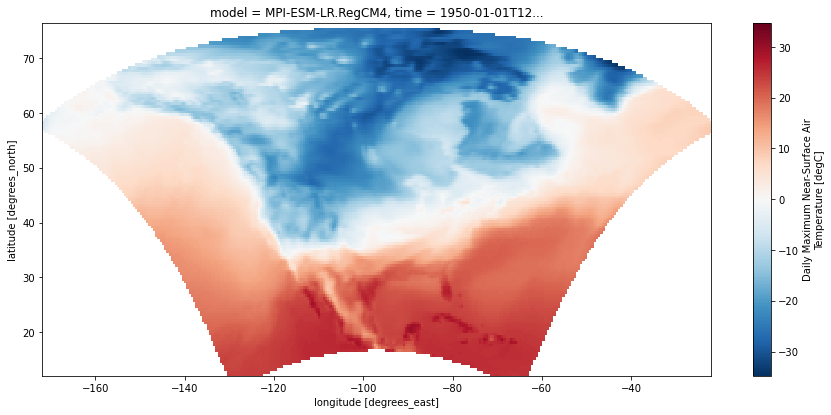

In [13]:
%%time

sim = 'MPI-ESM-LR.RegCM4'
date = "1950-01-01"
scen = "rcp85"

slice = ds['tmax'].sel(model=sim, time=date, scen=scen)

slice.plot(figsize=(15,6.5))

## Calculate freeze-thaw days from tmin & tmax

Different sources use different thresholds for defining freeze-thaw days, so these are adjustable parameters defaulting to -1 and 0 C.

In [9]:
## todo: add units parameter & check units attribute on inputs
## todo: mask missing data in inputs

def freezethaw(tmin, tmax, freeze_temp=-1, thaw_temp=0):
    """
    Calculate freeze-thaw days where tmin < freezing and tmax > freezing
    
    Params:
        tmin, tmax: two xarray DataArrays daily min & max temperatures
        freeze_temp: threshold for tmin; defaults to -1 (units assumed degC)
        thaw_temp: threshold for tmax; defaults to 0 (units assumed degC)
    """
    
    result = (tmin < freeze_temp) & (tmax > thaw_temp)
    
    ## add 0*inputs to cast to float and add missing values back in
    result = result + tmin * 0 + tmax * 0

    return result    

## Set up calculation

In [10]:
## This step only constructs the task graph.
## The computation doesn't happen until needed or explicitly called.

ds["ftdays"] = freezethaw(ds["tmin"], ds["tmax"])

## check strucutre of result
ds["ftdays"]

,Array,Chunk
Bytes,257.82 GB,78.00 MB
Shape,"(2, 15, 55517, 129, 300)","(1, 2, 1000, 65, 150)"
Count,83066 Tasks,5376 Chunks
Type,float32,numpy.ndarray


### Plot a single timestep to check that results look reasonable

CPU times: user 145 ms, sys: 11.3 ms, total: 156 ms
Wall time: 1.68 s


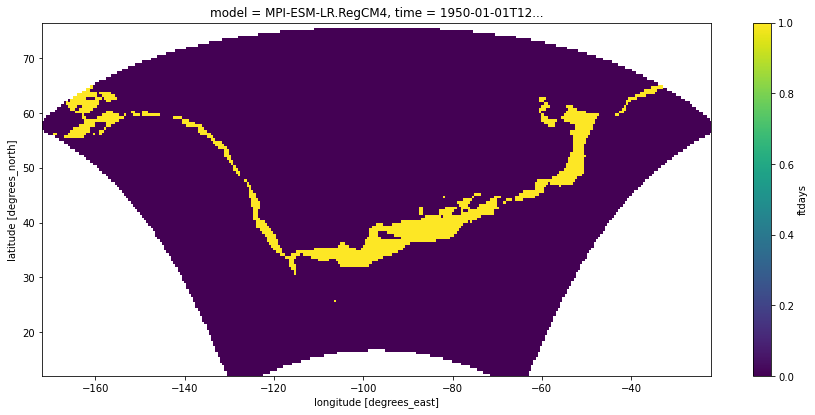

In [12]:
%%time

sim = 'MPI-ESM-LR.RegCM4'
date = "1950-01-01"
scen = "rcp85"

slice = ds["ftdays"].sel(model=sim, time=date, scen=scen)

slice.plot(figsize=(15,6.5))

## Aggregate to yearly totals

In [75]:
annftdays = ds["ftdays"].groupby('time.year').sum('time', skipna=False)

annftdays

,Array,Chunk
Bytes,705.89 MB,78.00 kB
Shape,"(2, 15, 152, 129, 300)","(1, 2, 1, 65, 150)"
Count,166586 Tasks,14592 Chunks
Type,float32,numpy.ndarray


### Plot a single timestep to check that results look reasonable

CPU times: user 265 ms, sys: 21.7 ms, total: 287 ms
Wall time: 3.66 s


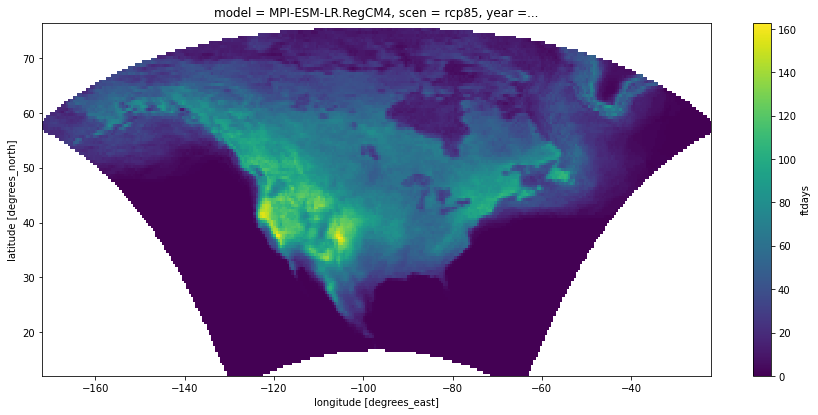

In [76]:
%%time

sim = 'MPI-ESM-LR.RegCM4'
year = 1979
scen = "rcp85"

slice = annftdays.sel(model=sim, year=year, scen=scen)

slice.plot(figsize=(15,6.5))

## Calculate ensemble statistics

Split the data into three ensembles and calculate ensemble min, max, mean, and median.
The ensembles are the rcp45 runs, the corresponding rcp85 runs, and the rcp85 runs that do not have a matching rcp45 run.

In [95]:
ensds = xr.Dataset()
ensds['e45pair'] = annftdays.sel(scen="rcp45", model=ens_pair).squeeze()
ensds['e85pair'] = annftdays.sel(scen="rcp85", model=ens_pair).squeeze()
ensds['e85solo'] = annftdays.sel(scen="rcp85", model=ens_solo).squeeze()

In [97]:
ensds

,Array,Chunk
Bytes,141.18 MB,39.00 kB
Shape,"(6, 152, 129, 300)","(1, 1, 65, 150)"
Count,177530 Tasks,3648 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,141.18 MB,39.00 kB
Shape,"(6, 152, 129, 300)","(1, 1, 65, 150)"
Count,177530 Tasks,3648 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [114]:
ensembles = list(ensds.keys())

In [116]:
## This doesn't work, but I'm not sure why

# estats = xr.Dataset()

# for stat in ("min", "max", "mean", "median"):
#     for e in ensembles:
#         estats[e + '.' + stat] = getattr(xr.DataArray, stat)(ensds[e], "model")

In [126]:
estats = xr.Dataset()

for e in ensembles:
    estats[e + ".min"]    = ensds[e].min("model", skipna=False)
    estats[e + ".max"]    = ensds[e].max("model", skipna=False)
    estats[e + ".mean"]   = ensds[e].mean("model", skipna=False)
#    estats[e + ".median"] = ensds[e].median("model", skipna=False)
## median is not yet implemented on Dask arrays...

estats

<xarray.Dataset>
Dimensions:       (lat: 129, lon: 300, year: 152)
Coordinates:
  * lat           (lat) float64 12.25 12.75 13.25 13.75 ... 75.25 75.75 76.25
  * lon           (lon) float64 -171.8 -171.2 -170.8 ... -23.25 -22.75 -22.25
    scen          <U5 'rcp45'
  * year          (year) int64 1949 1950 1951 1952 1953 ... 2097 2098 2099 2100
Data variables:
    e45pair.min   (year, lat, lon) float32 dask.array<chunksize=(1, 65, 150), meta=np.ndarray>
    e45pair.max   (year, lat, lon) float32 dask.array<chunksize=(1, 65, 150), meta=np.ndarray>
    e45pair.mean  (year, lat, lon) float32 dask.array<chunksize=(1, 65, 150), meta=np.ndarray>
    e85pair.min   (year, lat, lon) float32 dask.array<chunksize=(1, 65, 150), meta=np.ndarray>
    e85pair.max   (year, lat, lon) float32 dask.array<chunksize=(1, 65, 150), meta=np.ndarray>
    e85pair.mean  (year, lat, lon) float32 dask.array<chunksize=(1, 65, 150), meta=np.ndarray>
    e85solo.min   (year, lat, lon) float32 dask.array<chunksize=(1, 65, 150), meta=np.ndarray>
    e85solo.max   (year, lat, lon) float32 dask.array<chunksize=(1, 65, 150), meta=np.ndarray>
    e85solo.mean  (year, lat, lon) float32 dask.array<chunksize=(1, 65, 150), meta=np.ndarray>

### Plot some test results

CPU times: user 568 ms, sys: 36.9 ms, total: 605 ms
Wall time: 3.97 s


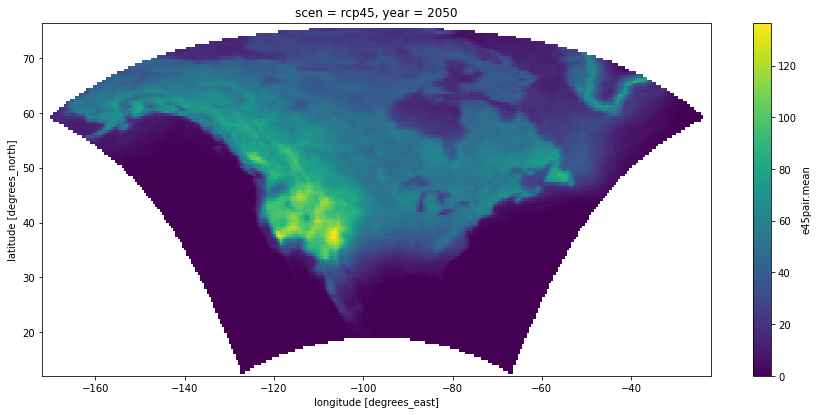

In [128]:
%%time

estats['e45pair.mean'].sel(year=2050).plot(figsize=(15,6.5))

## Write results to netcdf

In [ ]:
# xarrayobject.to_netcdf("filepath")
# look at brian's zarrify notebook for metadata examples

In [ ]:
annualft

### Release the workers.

In [ ]:
!date

In [ ]:
cluster.close()

#### Create Single Map Plot (Helper Function)

### Create Time Series Plots over Multiple Pages
These also mark the locations of missing values.

In [ ]:
def plot_timeseries(ds, data_var, store_name, plotdir):
    # Generate plot. 
    #
    # With 30 workers, expect 1 minute walltime for computation and 1-2 minutes for plot rendering.
    #
    member_names = ds.coords['member_id'].values
    numEnsembleMembers = member_names.size

    numPlotsPerPage = 4
    numPages = np.ceil(numEnsembleMembers / numPlotsPerPage).astype(int)
    numPlotCols = 1

    figWidth = 25 
    figHeight = 20

    linewidth = 0.5

    pp = PdfPages(f'{plotdir}/{store_name}_ts.pdf')

    for pageNum in range(numPages):

        memberStart = pageNum * numPlotsPerPage
        memberEnd = np.min((memberStart + numPlotsPerPage, numEnsembleMembers))
        plot_row_index = 0
        
        # If this is the final page, target empty subplots for hiding.
        removeBlankSubplots = (pageNum == numPages-1) and (numEnsembleMembers < memberStart + numPlotsPerPage)

        # Plot the aggregate statistics across time.
        fig, axs = plt.subplots(numPlotsPerPage, numPlotCols, figsize=(figWidth, figHeight))
        #fig, axs = plt.subplots(numPlotsPerPage, numPlotCols, figsize=(figWidth, figHeight), sharey='col')

        print(f'Shape of subplots object: {axs.shape}')
        
        
        for index in np.arange(memberStart, memberEnd):
            mem_id = member_names[index]
            data_slice = ds[data_var].sel(member_id=mem_id)
            unit_string = ds[data_var].attrs['units']
            
            min_vals = data_slice.min(dim = ['lat', 'lon'])
            max_vals = data_slice.max(dim = ['lat', 'lon'])
            mean_vals = data_slice.mean(dim = ['lat', 'lon'])
            std_vals = data_slice.std(dim = ['lat', 'lon'])

            nan_indexes = np.isnan(min_vals)
            nan_times = ds.time[nan_indexes]

            axs[plot_row_index].plot(ds.time, min_vals, linewidth=linewidth, label='min')
            axs[plot_row_index].plot(ds.time, max_vals, linewidth=linewidth, label='max')
            axs[plot_row_index].plot(ds.time, mean_vals, linewidth=linewidth, label='mean')
            axs[plot_row_index].plot(ds.time, std_vals, linewidth=linewidth, label='std')
            
            ymin, ymax = axs[plot_row_index].get_ylim()
            rug_y = ymin + 0.01*(ymax-ymin)
            axs[plot_row_index].plot(nan_times, [rug_y]*len(nan_times), '|', color='m', label='isnan')
            axs[plot_row_index].set_title(mem_id, fontsize=20)
            axs[plot_row_index].legend(loc='upper right')
            axs[plot_row_index].set_ylabel(unit_string)

            plot_row_index = plot_row_index + 1

        plt.suptitle(store_name, fontsize=25)
        plt.tight_layout(pad=10.2, w_pad=3.5, h_pad=3.5)
        
        if removeBlankSubplots:
            hide_subplots(axs, plot_row_index)
            
        pp.savefig()
        plt.close()
    pp.close()


#### Function Producing Maps of First, Middle, Last Timesteps

In [ ]:
def getValidDateIndexes(member_slice):
    '''Search for the first and last dates with finite values.'''
    min_values = member_slice.min(dim = ['lat', 'lon'])
    is_finite = np.isfinite(min_values)
    finite_indexes = np.where(is_finite)
    start_index = finite_indexes[0][0]
    end_index = finite_indexes[0][-1]
    #print(f'start ={start_index}, end={end_index}')
    return start_index, end_index


def plot_first_mid_last(ds, data_var, store_name, plotdir):
    # Generate plot. 
    #
    # With 30 workers, expect 1 minute walltime for computation and 1-2 minutes for plot rendering.
    #
    member_names = ds.coords['member_id'].values
    numEnsembleMembers = member_names.size

    numPlotsPerPage = 4
    numPages = np.ceil(numEnsembleMembers / numPlotsPerPage).astype(int)
    numPlotCols = 3

    figWidth = 18 
    figHeight = 12 #20

    pp = PdfPages(f'{plotdir}/{store_name}_fml.pdf')

    for pageNum in range(numPages):

        memberStart = pageNum * numPlotsPerPage
        memberEnd = np.min((memberStart + numPlotsPerPage, numEnsembleMembers))
        plot_row_index = 0

        # If this is the final page, target empty subplots for hiding.
        removeBlankSubplots = (pageNum == numPages-1) and (numEnsembleMembers < memberStart + numPlotsPerPage)

        # Plot the aggregate statistics across time.
        fig, axs = plt.subplots(numPlotsPerPage, numPlotCols, figsize=(figWidth, figHeight), constrained_layout=True)

        for index in np.arange(memberStart, memberEnd):
            mem_id = member_names[index]
            data_slice = ds[data_var].sel(member_id=mem_id)
            
            start_index, end_index = getValidDateIndexes(data_slice)
            midDateIndex = np.floor(len(ds.time) / 2).astype(int)

            startDate = ds.time[start_index]
            first_step = data_slice.sel(time=startDate) 
            ax = axs[plot_row_index, 0]
            plotMap(ax, first_step, startDate, mem_id)

            midDate = ds.time[midDateIndex]
            mid_step = data_slice.sel(time=midDate)   
            ax = axs[plot_row_index, 1]
            plotMap(ax, mid_step, midDate)

            endDate = ds.time[end_index]
            last_step = data_slice.sel(time=endDate)            
            ax = axs[plot_row_index, 2]
            plotMap(ax, last_step, endDate)
            
            plot_row_index = plot_row_index + 1
 
        plt.suptitle(store_name, fontsize=20)

        if removeBlankSubplots:
            hide_subplots(axs, plot_row_index)
            
        pp.savefig()
        plt.close()

    pp.close()

### Loop over Zarr Stores in Directory and Make Plots.

In [ ]:
# For now, make the Zarr output directory a global variable.
#dirout = '/glade/scratch/bonnland/na-cordex/zarr-demo'
zarr_directory = '/glade/scratch/bonnland/na-cordex/zarr-publish/'
#plot_directory = '/glade/scratch/bonnland/na-cordex/zarr-plots-test/'
plot_directory = "."

p = Path(zarr_directory)
stores = list(p.rglob("*.zarr"))
#stores = list(p.rglob("uas.rcp85.*.zarr"))
stores = list(p.rglob("tmax.rcp85.day.NAM-44i.raw.zarr"))
for store in stores:
    print(f'Opening {store}...')
    try:
        ds = xr.open_zarr(store.as_posix(), consolidated=True)
        print('\n')
    except Exception as e:
        print(e)
        continue
    data_vars = [vname for vname in ds.data_vars]
    data_var = data_vars[0]
    store_name = store.as_posix().split('/')[-1]
    
    # Only produce plots that haven't been created already.  
    plotdir = plot_directory + store_name
    if not os.path.exists(plotdir):
        os.makedirs(plotdir)
    else:
        # Plots exist; skip to the next case.
        continue
    
    plot_stat_maps(ds, data_var, store_name, plotdir)
    plot_first_mid_last(ds, data_var, store_name, plotdir)
    plot_timeseries(ds, data_var, store_name, plotdir)
    

## Unused Plot Functions

### Function producing Super-Wide Time Series Plots. 

In [ ]:
def plot_timeseries_wide(ds, data_var, store_name):
    # Generate super-wide plot of individual time series. 
    #
    # With 30 workers, expect 1 minute walltime for computation and 1-2 minutes for plot rendering.
    #
    member_names = ds.coords['member_id'].values
    numEnsembleMembers = member_names.size

    numPlotRows = numEnsembleMembers
    numPlotCols = 4

    figWidth = 200 #100 
    figHeight = 80

    linestyle = 'k.'
    linewidth = 0.5
    markersize = 0.5

    fig, axs = plt.subplots(numPlotRows, numPlotCols, figsize=(figWidth,figHeight), sharey='col')

    for index in range(numEnsembleMembers):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)

        data_agg = data_slice.min(dim=['lat', 'lon'])
        axs[index, 0].plot(ds.time, data_agg, linewidth=linewidth)
        axs[index, 0].plot(ds.time, data_agg, linestyle, markersize=markersize)
        axs[index, 0].set_ylabel(mem_id, fontsize=15)

        data_agg = data_slice.max(dim=['lat', 'lon'])
        axs[index, 1].plot(ds.time, data_agg, linewidth=linewidth)
        axs[index, 1].plot(ds.time, data_agg, linestyle, markersize=markersize)
        axs[index, 1].set_ylabel(mem_id, fontsize=15)

        data_agg = data_slice.mean(dim=['lat', 'lon'])
        axs[index, 2].plot(ds.time, data_agg, linewidth=linewidth)
        axs[index, 2].plot(ds.time, data_agg, linestyle, markersize=markersize)
        axs[index, 2].set_ylabel(mem_id, fontsize=15)

        data_agg = data_slice.std(dim=['lat', 'lon'])
        axs[index, 3].plot(ds.time, data_agg, linewidth=linewidth)
        axs[index, 3].plot(ds.time, data_agg, linestyle, markersize=markersize)
        axs[index, 3].set_ylabel(mem_id, fontsize=15)
       
    
    axs[0, 0].set_title(f'min({var})', fontsize=40)
    axs[0, 1].set_title(f'max({var})', fontsize=40)
    axs[0, 2].set_title(f'mean({var})', fontsize=40)
    axs[0, 3].set_title(f'std({var})', fontsize=40)
    

    plt.suptitle(store, fontsize=50)
    plt.tight_layout(pad=20.2, w_pad=5.5, h_pad=5.5)
    plt.savefig(f'{store_name}_ts.pdf')



#### Function Producing Map Plots Over a SINGLE Page

In [ ]:
def plot_maps_OLD(ds, data_var, store_name):
    # Generate plot. 
    #
    # With 30 workers, expect 1 minute walltime for computation and 1-2 minutes for plot rendering.
    #
    member_names = ds.coords['member_id'].values
    numEnsembleMembers = member_names.size

    numPlotsPerPage = 4
    numPages = np.ceil(numEnsembleMembers / numPlotsPerPage).astype(int)

    numPlotRows = numEnsembleMembers
    numPlotCols = 4

    figWidth = 17 
    figHeight = 35

    fig, axs = plt.subplots(numPlotRows, numPlotCols, figsize=(figWidth,figHeight), constrained_layout=True)

    for index in range(numEnsembleMembers):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)

        data_agg = data_slice.min(dim='time')
        pcm0 = axs[index, 0].imshow(data_agg, origin='lower')
        axs[index, 0].set_ylabel(mem_id, fontsize=8)

        data_agg = data_slice.max(dim='time')
        pcm1 = axs[index, 1].imshow(data_agg, origin='lower')
        axs[index, 1].set_ylabel(mem_id, fontsize=8)

        data_agg = data_slice.mean(dim='time')
        pcm2 = axs[index, 2].imshow(data_agg, origin='lower')
        axs[index, 2].set_ylabel(mem_id, fontsize=8)

        data_agg = data_slice.std(dim='time')
        pcm3 = axs[index, 3].imshow(data_agg, origin='lower')
        axs[index, 3].set_ylabel(mem_id, fontsize=8)
       
    
    axs[0, 0].set_title(f'min({var})', fontsize=15)
    axs[0, 1].set_title(f'max({var})', fontsize=15)
    axs[0, 2].set_title(f'mean({var})', fontsize=15)
    axs[0, 3].set_title(f'std({var})', fontsize=15)
    
    plt.colorbar(pcm0, ax = axs[:, 0], location='bottom', shrink=0.7)
    plt.colorbar(pcm1, ax = axs[:, 1], location='bottom', shrink=0.7)
    plt.colorbar(pcm2, ax = axs[:, 2], location='bottom', shrink=0.7)
    plt.colorbar(pcm3, ax = axs[:, 3], location='bottom', shrink=0.7)

    plt.suptitle(store_name, fontsize=20)
    plt.savefig(f'{store_name}_maps.pdf')
